# Species comparison: conservation

**Purpose**: To compare the conservation of polyA regions across yeast species and humans.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

In [4]:
import statsmodels.stats.api as sm

## IMPORTS AND SETUP

In [5]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
DATADIR   = os.path.join(PROJECT, 'external_data', 'conservation')
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'species_comparison')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
## Load CDS region conservation scores

with open(os.path.join(RESOURCES, 'conservation.cds_scores.pickle'), mode = 'rb') as handle:
    cds_scores = pickle.load(handle)


In [7]:
## Load conservation profiles surrounding polyA sites

with open(os.path.join(RESOURCES, 'conservation.top1_sites.pickle'), mode = 'rb') as handle:
    top1_data = pickle.load(handle)

with open(os.path.join(RESOURCES, 'conservation.gold_sites.pickle'), mode = 'rb') as handle:
    gold_data = pickle.load(handle)

print("Top1 site conservation data:", top1_data.shape)
print("Gold site conservation data:", gold_data.shape)


Top1 site conservation data: (25603, 20)
Gold site conservation data: (32797, 20)


In [8]:
## Load conservation scores for motifs surrounding polyA sites

with open(os.path.join(RESOURCES, 'conservation.top1_motifs.pickle'), mode = 'rb') as handle:
    top1_motifs = pickle.load(handle)

with open(os.path.join(RESOURCES, 'conservation.gold_motifs.pickle'), mode = 'rb') as handle:
    gold_motifs = pickle.load(handle)

print("Top1 motif conservation data:", top1_motifs.shape)
print("Gold motif conservation data:", gold_motifs.shape)


Top1 motif conservation data: (4702995, 18)
Gold motif conservation data: (7011675, 19)


# ANALYSIS

## Conservation analysis

In [9]:
species_order = ['S.cerevisiae','S.pombe','H.sapiens']

species_palette = {
    'S.cerevisiae' : sns.color_palette("Set2")[0],
    'S.pombe'      : sns.color_palette("Set2")[1],
    'H.sapiens'    : sns.color_palette("Set2")[2],
}

mot_cmap_scer = {
    'A-rich'        : '#2278B5',
    'A-rich_d0'     : '#2278B5',
    'A-rich_d1'     : '#6AB1E3',
    'A-rich_d2'     : '#9CCBEC',
    'T-rich'        : '#2FA148',
    'T-rich_d0'     : '#2FA148',
    'T-rich_d1'     : '#73D689',
    'T-rich_d2'     : '#A1E4B0',
    'TA/TA-rich'    : '#D62A28',
    'TA/TA-rich_d0' : '#D62A28',
    'TA/TA-rich_d1' : '#E77F7E',
    'TA/TA-rich_d2' : '#EFAAA9',
    'G/A-rich'      : '#956CB4',
    'G/A-rich_d0'   : '#956CB4',
    'Other'         : '#000000',
    'Pattern'       : '#000000',
}

mot_cmap_spom = {
    'A-rich'        : '#2278b5',
    'A-rich_d0'     : '#2278b5',
    'A-rich_d1'     : '#6ab1e3',
    'A-rich_d2'     : '#9ccbec',
    'A-rich_d3'     : '#cde5f5',
    'T-rich'        : '#2fa148',
    'T-rich_d0'     : '#2fa148',
    'T-rich_d1'     : '#73d689',
    'T-rich_d2'     : '#a1e4b0',
    'GTA'           : '#fcb316',
    'GTA_d0'        : '#fcb316',
    'TAG'           : '#8C0800',
    'TAG_d0'        : '#8C0800',
    'GTA-TAG'       : '#D55E00',
    'GTA-TAG_d0'    : '#D55E00',
    'GTA_controls'  : '#6d6e71',
    'Other'         : '#000000',
    'Pattern'       : '#000000',
}


### PhastCons conservation profile around top sites

In [10]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [11]:
def conservation_by_position(data):
    
    xcons = [mean_confidence_interval(data[:,x]) for x in range(np.shape(data)[1])]
    xmeans, xlows, xhighs = zip(*xcons)
    
    return np.asarray(xmeans), np.asarray(xlows), np.asarray(xhighs)


In [12]:
def calculate_conservation_profile(data, species, cds_mean, conserved, verbose = False):
    
    if (conserved == True) or (conserved == False):
        edt = np.nan_to_num(np.asarray(data.loc[(data['species'] == species) & (data['conserved_yeast_to_human'] == conserved), 'conservation'].tolist()), nan = 0)
    else:
        edt = np.nan_to_num(np.asarray(data.loc[(data['species'] == species), 'conservation'].tolist()), nan = 0)
        
    enorm = edt / cds_mean
    emeans, elows, ehighs = conservation_by_position(enorm)
    
    if (verbose):
        print(species, np.shape(edt), np.min(emeans), np.max(emeans))
    
    return emeans, elows, ehighs


#### Top sites located in homologous genes

S.cerevisiae (3296, 500) 0.4266518859922217 1.0305807007908898
S.pombe (2720, 500) 0.29654687978638744 0.9013222290119437
H.sapiens (3777, 500) 0.15036384508069262 0.9927579735071194


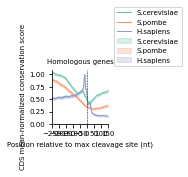

In [13]:
fig,ax = plt.subplots(1,1, figsize = (1,1))

xs = np.arange(-250,250,1)
region = (-250,150)

emeans_cerev, elows_cerev, ehighs_cerev = calculate_conservation_profile(top1_data, "S.cerevisiae", cds_scores['scer']['mean'], conserved = True, verbose = True)
emeans_pombe, elows_pombe, ehighs_pombe = calculate_conservation_profile(top1_data, "S.pombe",      cds_scores['spom']['mean'], conserved = True, verbose = True)
emeans_human, elows_human, ehighs_human = calculate_conservation_profile(top1_data, "H.sapiens",    cds_scores['hsap']['mean'], conserved = True, verbose = True)

ax.plot(xs, emeans_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", linewidth = 1)
ax.fill_between(xs, y1 = elows_cerev, y2 = ehighs_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_pombe, color = species_palette['S.pombe'], label = "S.pombe", linewidth = 1)
ax.fill_between(xs, y1 = elows_pombe, y2 = ehighs_pombe, color = species_palette['S.pombe'], label = "S.pombe", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_human, color = species_palette['H.sapiens'], label = "H.sapiens", linewidth = 1)
ax.fill_between(xs, y1 = elows_human, y2 = ehighs_human, color = species_palette['H.sapiens'], label = "H.sapiens", alpha = 0.25, zorder = 0)

ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(0,1.1)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.set_xlabel("Position relative to max cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_title("Homologous genes", fontsize = 7)

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'species_conservation_comparison.golden_top-1.homologous.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Top sites located in non-homologous genes

S.cerevisiae (2225, 500) 0.42574995667799953 0.8701409551071113
S.pombe (1260, 500) 0.23050023168109032 0.6268108356599903
H.sapiens (12325, 500) 0.13522730185952286 0.9282388423946593


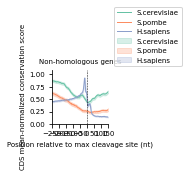

In [14]:
fig,ax = plt.subplots(1,1, figsize = (1,1))

xs = np.arange(-250,250,1)
region = (-250,150)

emeans_cerev, elows_cerev, ehighs_cerev = calculate_conservation_profile(top1_data, "S.cerevisiae", cds_scores['scer']['mean'], conserved = False, verbose = True)
emeans_pombe, elows_pombe, ehighs_pombe = calculate_conservation_profile(top1_data, "S.pombe",      cds_scores['spom']['mean'], conserved = False, verbose = True)
emeans_human, elows_human, ehighs_human = calculate_conservation_profile(top1_data, "H.sapiens",    cds_scores['hsap']['mean'], conserved = False, verbose = True)

ax.plot(xs, emeans_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", linewidth = 1)
ax.fill_between(xs, y1 = elows_cerev, y2 = ehighs_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_pombe, color = species_palette['S.pombe'], label = "S.pombe", linewidth = 1)
ax.fill_between(xs, y1 = elows_pombe, y2 = ehighs_pombe, color = species_palette['S.pombe'], label = "S.pombe", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_human, color = species_palette['H.sapiens'], label = "H.sapiens", linewidth = 1)
ax.fill_between(xs, y1 = elows_human, y2 = ehighs_human, color = species_palette['H.sapiens'], label = "H.sapiens", alpha = 0.25, zorder = 0)

ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(0,1.1)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.set_xlabel("Position relative to max cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_title("Non-homologous genes", fontsize = 7)

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'species_conservation_comparison.golden_top-1.nonhomologous.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### All top sites

S.cerevisiae (5521, 500) 0.42968663854230954 0.9655000714528255
S.pombe (3980, 500) 0.28027547198560804 0.814087154287177
H.sapiens (16102, 500) 0.1396875701702457 0.9433729101012649


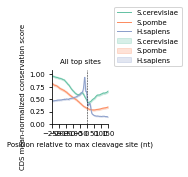

In [15]:
fig,ax = plt.subplots(1,1, figsize = (1,1))

xs = np.arange(-250,250,1)
region = (-250,150)

emeans_cerev, elows_cerev, ehighs_cerev = calculate_conservation_profile(top1_data, "S.cerevisiae", cds_scores['scer']['mean'], conserved = 'NA', verbose = True)
emeans_pombe, elows_pombe, ehighs_pombe = calculate_conservation_profile(top1_data, "S.pombe",      cds_scores['spom']['mean'], conserved = 'NA', verbose = True)
emeans_human, elows_human, ehighs_human = calculate_conservation_profile(top1_data, "H.sapiens",    cds_scores['hsap']['mean'], conserved = 'NA', verbose = True)

ax.plot(xs, emeans_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", linewidth = 1)
ax.fill_between(xs, y1 = elows_cerev, y2 = ehighs_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_pombe, color = species_palette['S.pombe'], label = "S.pombe", linewidth = 1)
ax.fill_between(xs, y1 = elows_pombe, y2 = ehighs_pombe, color = species_palette['S.pombe'], label = "S.pombe", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_human, color = species_palette['H.sapiens'], label = "H.sapiens", linewidth = 1)
ax.fill_between(xs, y1 = elows_human, y2 = ehighs_human, color = species_palette['H.sapiens'], label = "H.sapiens", alpha = 0.25, zorder = 0)

ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(0,1.1)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.set_xlabel("Position relative to max cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_title("All top sites", fontsize = 7)

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'species_conservation_comparison.golden_top-1.all.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


### Split by entropy group and show conservation profile

S.cerevisiae (1104, 500) 0.3902790076536574 0.97857051222262
S.pombe (796, 500) 0.253706926153047 0.8629101980419566
H.sapiens (3221, 500) 0.132329957582822 0.9118408957142923


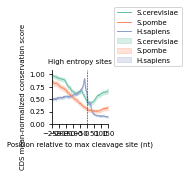

In [16]:
fig,ax = plt.subplots(1,1, figsize = (1,1))

xs = np.arange(-250,250,1)
region = (-250,150)

emeans_cerev, elows_cerev, ehighs_cerev = calculate_conservation_profile(top1_data.loc[top1_data['observed_entropy_bin'] == 'H'], "S.cerevisiae", cds_scores['scer']['mean'], conserved = 'NA', verbose = True)
emeans_pombe, elows_pombe, ehighs_pombe = calculate_conservation_profile(top1_data.loc[top1_data['observed_entropy_bin'] == 'H'], "S.pombe",      cds_scores['spom']['mean'], conserved = 'NA', verbose = True)
emeans_human, elows_human, ehighs_human = calculate_conservation_profile(top1_data.loc[top1_data['observed_entropy_bin'] == 'H'], "H.sapiens",    cds_scores['hsap']['mean'], conserved = 'NA', verbose = True)

ax.plot(xs, emeans_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", linewidth = 1)
ax.fill_between(xs, y1 = elows_cerev, y2 = ehighs_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_pombe, color = species_palette['S.pombe'], label = "S.pombe", linewidth = 1)
ax.fill_between(xs, y1 = elows_pombe, y2 = ehighs_pombe, color = species_palette['S.pombe'], label = "S.pombe", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_human, color = species_palette['H.sapiens'], label = "H.sapiens", linewidth = 1)
ax.fill_between(xs, y1 = elows_human, y2 = ehighs_human, color = species_palette['H.sapiens'], label = "H.sapiens", alpha = 0.25, zorder = 0)

ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(0,1.1)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.set_xlabel("Position relative to max cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_title("High entropy sites", fontsize = 7)

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'species_conservation_comparison.golden_top-1.entropy_high.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


S.cerevisiae (1105, 500) 0.46250928628691396 0.9636975475163515
S.pombe (796, 500) 0.3217348331318674 0.7426376648262116
H.sapiens (3221, 500) 0.12696512931662565 0.9293695562974401


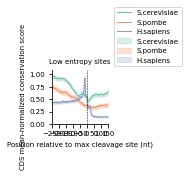

In [17]:
fig,ax = plt.subplots(1,1, figsize = (1,1))

xs = np.arange(-250,250,1)
region = (-250,150)

emeans_cerev, elows_cerev, ehighs_cerev = calculate_conservation_profile(top1_data.loc[top1_data['observed_entropy_bin'] == 'L'], "S.cerevisiae", cds_scores['scer']['mean'], conserved = 'NA', verbose = True)
emeans_pombe, elows_pombe, ehighs_pombe = calculate_conservation_profile(top1_data.loc[top1_data['observed_entropy_bin'] == 'L'], "S.pombe",      cds_scores['spom']['mean'], conserved = 'NA', verbose = True)
emeans_human, elows_human, ehighs_human = calculate_conservation_profile(top1_data.loc[top1_data['observed_entropy_bin'] == 'L'], "H.sapiens",    cds_scores['hsap']['mean'], conserved = 'NA', verbose = True)

ax.plot(xs, emeans_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", linewidth = 1)
ax.fill_between(xs, y1 = elows_cerev, y2 = ehighs_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_pombe, color = species_palette['S.pombe'], label = "S.pombe", linewidth = 1)
ax.fill_between(xs, y1 = elows_pombe, y2 = ehighs_pombe, color = species_palette['S.pombe'], label = "S.pombe", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_human, color = species_palette['H.sapiens'], label = "H.sapiens", linewidth = 1)
ax.fill_between(xs, y1 = elows_human, y2 = ehighs_human, color = species_palette['H.sapiens'], label = "H.sapiens", alpha = 0.25, zorder = 0)

ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(0,1.1)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.set_xlabel("Position relative to max cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_title("Low entropy sites", fontsize = 7)

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'species_conservation_comparison.golden_top-1.entropy_low.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Conservation profile based on the relative position of well-expressed sites

S.cerevisiae (2740, 500) 0.42499370871879033 1.0718459603484156
S.pombe (553, 500) 0.18452332708573882 1.1528083001877534
H.sapiens (4479, 500) 0.3107784068011448 0.8724484068783442


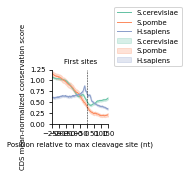

In [18]:
fig,ax = plt.subplots(1,1, figsize = (1,1))

xs = np.arange(-250,250,1)
region = (-250,150)

position = 'first'

emeans_cerev, elows_cerev, ehighs_cerev = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "S.cerevisiae", cds_scores['scer']['mean'], conserved = 'NA', verbose = True)
emeans_pombe, elows_pombe, ehighs_pombe = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "S.pombe",      cds_scores['spom']['mean'], conserved = 'NA', verbose = True)
emeans_human, elows_human, ehighs_human = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "H.sapiens",    cds_scores['hsap']['mean'], conserved = 'NA', verbose = True)

ax.plot(xs, emeans_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", linewidth = 1)
ax.fill_between(xs, y1 = elows_cerev, y2 = ehighs_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_pombe, color = species_palette['S.pombe'], label = "S.pombe", linewidth = 1)
ax.fill_between(xs, y1 = elows_pombe, y2 = ehighs_pombe, color = species_palette['S.pombe'], label = "S.pombe", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_human, color = species_palette['H.sapiens'], label = "H.sapiens", linewidth = 1)
ax.fill_between(xs, y1 = elows_human, y2 = ehighs_human, color = species_palette['H.sapiens'], label = "H.sapiens", alpha = 0.25, zorder = 0)

ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(0,1.25)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.set_xlabel("Position relative to max cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_title(f"{position.capitalize()} sites", fontsize = 7)

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'species_conservation_comparison.golden_reads.{position}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


S.cerevisiae (4393, 500) 0.42376665499188454 1.0982411539773946
S.pombe (456, 500) 0.17424343360418562 1.2180412197997392
H.sapiens (2983, 500) 0.24977305381895404 0.7314373878872125


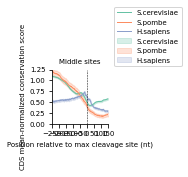

In [19]:
fig,ax = plt.subplots(1,1, figsize = (1,1))

xs = np.arange(-250,250,1)
region = (-250,150)

position = 'middle'

emeans_cerev, elows_cerev, ehighs_cerev = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "S.cerevisiae", cds_scores['scer']['mean'], conserved = 'NA', verbose = True)
emeans_pombe, elows_pombe, ehighs_pombe = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "S.pombe",      cds_scores['spom']['mean'], conserved = 'NA', verbose = True)
emeans_human, elows_human, ehighs_human = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "H.sapiens",    cds_scores['hsap']['mean'], conserved = 'NA', verbose = True)

ax.plot(xs, emeans_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", linewidth = 1)
ax.fill_between(xs, y1 = elows_cerev, y2 = ehighs_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_pombe, color = species_palette['S.pombe'], label = "S.pombe", linewidth = 1)
ax.fill_between(xs, y1 = elows_pombe, y2 = ehighs_pombe, color = species_palette['S.pombe'], label = "S.pombe", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_human, color = species_palette['H.sapiens'], label = "H.sapiens", linewidth = 1)
ax.fill_between(xs, y1 = elows_human, y2 = ehighs_human, color = species_palette['H.sapiens'], label = "H.sapiens", alpha = 0.25, zorder = 0)

ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(0,1.25)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.set_xlabel("Position relative to max cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_title(f"{position.capitalize()} sites", fontsize = 7)

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'species_conservation_comparison.golden_reads.{position}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


S.cerevisiae (2740, 500) 0.3949537631383353 0.9997371010403137
S.pombe (553, 500) 0.18297221169793365 1.0322260842448039
H.sapiens (4479, 500) 0.10861635393008641 0.8188674867176922


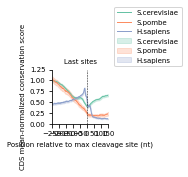

In [20]:
fig,ax = plt.subplots(1,1, figsize = (1,1))

xs = np.arange(-250,250,1)
region = (-250,150)

position = 'last'

emeans_cerev, elows_cerev, ehighs_cerev = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "S.cerevisiae", cds_scores['scer']['mean'], conserved = 'NA', verbose = True)
emeans_pombe, elows_pombe, ehighs_pombe = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "S.pombe",      cds_scores['spom']['mean'], conserved = 'NA', verbose = True)
emeans_human, elows_human, ehighs_human = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "H.sapiens",    cds_scores['hsap']['mean'], conserved = 'NA', verbose = True)

ax.plot(xs, emeans_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", linewidth = 1)
ax.fill_between(xs, y1 = elows_cerev, y2 = ehighs_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_pombe, color = species_palette['S.pombe'], label = "S.pombe", linewidth = 1)
ax.fill_between(xs, y1 = elows_pombe, y2 = ehighs_pombe, color = species_palette['S.pombe'], label = "S.pombe", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_human, color = species_palette['H.sapiens'], label = "H.sapiens", linewidth = 1)
ax.fill_between(xs, y1 = elows_human, y2 = ehighs_human, color = species_palette['H.sapiens'], label = "H.sapiens", alpha = 0.25, zorder = 0)

ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(0,1.25)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.set_xlabel("Position relative to max cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_title(f"{position.capitalize()} sites", fontsize = 7)

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'species_conservation_comparison.golden_reads.{position}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


S.cerevisiae (1160, 500) 0.3571364983239015 0.9504046275057481
S.pombe (825, 500) 0.2007308960670924 0.8666986538797266
H.sapiens (7436, 500) 0.10836027237990474 1.0585013810138355


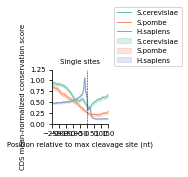

In [21]:
fig,ax = plt.subplots(1,1, figsize = (1,1))

xs = np.arange(-250,250,1)
region = (-250,150)

position = 'single'

emeans_cerev, elows_cerev, ehighs_cerev = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "S.cerevisiae", cds_scores['scer']['mean'], conserved = 'NA', verbose = True)
emeans_pombe, elows_pombe, ehighs_pombe = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "S.pombe",      cds_scores['spom']['mean'], conserved = 'NA', verbose = True)
emeans_human, elows_human, ehighs_human = calculate_conservation_profile(gold_data.loc[gold_data['position'] == position], "H.sapiens",    cds_scores['hsap']['mean'], conserved = 'NA', verbose = True)

ax.plot(xs, emeans_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", linewidth = 1)
ax.fill_between(xs, y1 = elows_cerev, y2 = ehighs_cerev, color = species_palette['S.cerevisiae'], label = "S.cerevisiae", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_pombe, color = species_palette['S.pombe'], label = "S.pombe", linewidth = 1)
ax.fill_between(xs, y1 = elows_pombe, y2 = ehighs_pombe, color = species_palette['S.pombe'], label = "S.pombe", alpha = 0.25, zorder = 0)

ax.plot(xs, emeans_human, color = species_palette['H.sapiens'], label = "H.sapiens", linewidth = 1)
ax.fill_between(xs, y1 = elows_human, y2 = ehighs_human, color = species_palette['H.sapiens'], label = "H.sapiens", alpha = 0.25, zorder = 0)

ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(0,1.25)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.set_xlabel("Position relative to max cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_title(f"{position.capitalize()} sites", fontsize = 7)

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'species_conservation_comparison.golden_reads.{position}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


### PhastCons conservation scores for motifs around top sites

In [22]:
## Split species data

top1_mot_scer = top1_motifs.loc[top1_motifs['species'] == 'S.cerevisiae'].copy()
top1_mot_spom = top1_motifs.loc[top1_motifs['species'] == 'S.pombe'].copy()

print(top1_mot_scer.shape)
print(top1_mot_spom.shape)


(2732895, 18)
(1970100, 18)


In [23]:
## Tally the number of golden sites for each species

top1_sites_scer = top1_mot_scer['siteKey'].nunique()
top1_sites_spom = top1_mot_spom['siteKey'].nunique()

print(f"Number of golden sites: scer={top1_sites_scer}, spom={top1_sites_spom}")


Number of golden sites: scer=5521, spom=3980


#### Conservation scores for motifs in *S. cerevisiae*

In [43]:
## Summarize the motif conservation scores

condCONS = (top1_mot_scer['conserved_yeast_to_human'] == True)
condMISS = (top1_mot_scer['conservation_missing'] == False)

mdata_scer = top1_mot_scer.loc[condCONS & condMISS].copy()
print(f"Filtered motifs: input={len(top1_mot_scer)}, conserved={condCONS.sum()}, no_missing_values={condMISS.sum()}, both_conditions={(condCONS & condMISS).sum()}")

## Group motifs by family and significance

mdata_scer['category'] = np.nan
mdata_scer.loc[(mdata_scer['motifSignificance'] == False) & (mdata_scer['motifOverallFamily'] == 'Other'), 'category'] = 'Other'
mdata_scer.loc[(mdata_scer['motifSignificance'] == True ) & (mdata_scer['motifOverallFamily'] != 'Other'), 'category'] = mdata_scer['motifOverallFamily']

mdata_scer['category'] = pd.Categorical(mdata_scer['category'], categories = ['Other','TA/TA-rich','A-rich','T-rich'])

print(f"Motif groups: families={mdata_scer['category'].value_counts().to_dict()}, unassigned={mdata_scer['category'].isna().sum()}")


Filtered motifs: input=2732895, conserved=1631520, no_missing_values=2726491, both_conditions=1628815
Motif groups: families={'Other': 1053498, 'T-rich': 91909, 'A-rich': 66942, 'TA/TA-rich': 65826}, unassigned=350640


In [44]:
## Filter out rare motifs present in fewer than 1% of golden sites

motif_sites = mdata_scer.groupby('motif')['siteKey'].nunique()
motif_incl  = motif_sites.index[motif_sites >= (0.01 * mdata_scer['siteKey'].nunique())].to_list()
mfilt_scer  = mdata_scer.loc[mdata_scer['motif'].isin(motif_incl)].copy()

print(f"After filtering out rare motifs: threshold=1%, input_data={len(mdata_scer)}, filtered_data={len(mfilt_scer)}")


After filtering out rare motifs: threshold=1%, input_data=1628815, filtered_data=1628757


In [45]:
## Adjusted motif conservation scores by the mean CDS region score

mfilt_scer['conservation_adjusted'] = mfilt_scer['conservation_mean'] / cds_scores['scer']['mean']


In [46]:
## Identify the motifs located in the slight conservation peak

mreg = (-75,0)

mfilt_scer['region'] = pd.cut(mfilt_scer['motifRelPos'], bins = [-250,mreg[0]-1,mreg[1],150], labels = ['Upstream','Target','Downstream'])

mfilt_scer['target'] = 'Other'
mfilt_scer.loc[mfilt_scer['motifRelPos'].between(*mreg), 'target'] = 'Target'

print(mfilt_scer.groupby(['target','region']).size())


target  region    
Other   Upstream      573154
        Downstream    493168
Target  Target        250310
dtype: int64


In [47]:
## Summarize mean conservation score and frequency by position

msum_score_scer = mfilt_scer.groupby(['category','motifRelPos'])['conservation_mean'].agg(['mean','std']).reset_index()
msum_freq_scer  = mfilt_scer.groupby(['category','motifRelPos']).size().reset_index(name = 'count')


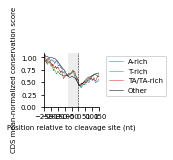

In [48]:
## Plot distribution of motif conservation scores around polyA sites

region = (-250,150)
smoothing = 10

fig,ax = plt.subplots(1,1, figsize = (1,1))

for c in sorted(mdata_scer.loc[(~mdata_scer['category'].isna()) & (mdata_scer['category'] != 'Other'), 'category'].unique().tolist()) + ['Other']:
    
    dt = msum_score_scer.loc[msum_score_scer['category'] == c]
    dc = dict(zip(dt['motifRelPos'], dt['mean']))
    
    xs = np.arange(*region,1)
    ys = np.asarray([dc.get(x,0) for x in xs]) / cds_scores['scer']['mean']
    sm = pd.Series(ys).rolling(window = smoothing, center = True).mean()
    
    sns.lineplot(x = xs, y = sm, label = c, color = mot_cmap_scer[c], linewidth = 0.5, ax = ax)

ax.axvspan(*mreg, color = '#ededed', zorder = 1)
ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_xlabel("Position relative to cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(0,1.1)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.legend(bbox_to_anchor = (1.05,1), loc = 'upper left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'motif_conservation_comparison.golden_top-1.scer.mean_score.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


Category     A-rich: unique_motifs=31
Category     T-rich: unique_motifs=51
Category TA/TA-rich: unique_motifs=40
Category      Other: unique_motifs=3535


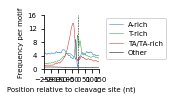

In [49]:
## Plot distribution of motif frequency around polyA sites

region = (-250,150)
smoothing = 10

fig,ax = plt.subplots(1,1, figsize = (1,1))

for c in sorted(mfilt_scer.loc[(~mfilt_scer['category'].isna()) & (mfilt_scer['category'] != 'Other'), 'category'].unique().tolist()) + ['Other']:
    print(f"Category {c:>10}: unique_motifs={mfilt_scer.loc[mfilt_scer['category'] == c, 'motif'].nunique()}")
    
    dt = msum_freq_scer.loc[msum_freq_scer['category'] == c]
    dc = dict(zip(dt['motifRelPos'], dt['count']))
    
    xs = np.arange(*region,1)
    ys = np.asarray([dc.get(x,0) for x in xs]) / mfilt_scer.loc[mfilt_scer['category'] == c, 'motif'].nunique()
    sm = pd.Series(ys).rolling(window = smoothing, center = True).mean()
    
    sns.lineplot(x = xs, y = sm, label = c, color = mot_cmap_scer[c], linewidth = 0.5, ax = ax)

ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_xlabel("Position relative to cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_ylabel("Frequency per motif")
ax.set_ylim(0,16)
ax.yaxis.set_major_locator(MultipleLocator(4))

ax.legend(bbox_to_anchor = (1.05,1), loc = 'upper left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'motif_conservation_comparison.golden_top-1.scer.frequency.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


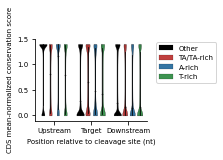


Corresponding statistics:
Wilcoxon rank-sum test for region=Upstream   TA/TA-rich vs Other: p=0.00E+00
Wilcoxon rank-sum test for region=Upstream       T-rich vs Other: p=0.00E+00
Wilcoxon rank-sum test for region=Upstream       A-rich vs Other: p=7.92E-47
Wilcoxon rank-sum test for region=Target         T-rich vs Other: p=2.16E-38
Wilcoxon rank-sum test for region=Target     TA/TA-rich vs Other: p=4.23E-284
Wilcoxon rank-sum test for region=Target         A-rich vs Other: p=3.49E-34
Wilcoxon rank-sum test for region=Downstream     A-rich vs Other: p=2.23E-29
Wilcoxon rank-sum test for region=Downstream TA/TA-rich vs Other: p=3.15E-12
Wilcoxon rank-sum test for region=Downstream     T-rich vs Other: p=4.59E-15

Summary data:
                          count      mean       std  min       max
region     category                                               
Upstream   Other       393782.0  0.910572  0.580713  0.0  1.401274
           TA/TA-rich   15151.0  0.734532  0.596969  0.0  1.401

In [50]:
## Assess statistical significance by comparing individual scores in the target region
## using a Wilcoxon rank sum test

fig,ax = plt.subplots(1,1, figsize = (2,1.5))

sns.violinplot(data = mfilt_scer, x = 'region', y = 'conservation_adjusted', order = ['Upstream','Target','Downstream'],
               hue = 'category', palette = mot_cmap_scer, 
               density_norm = 'area', common_norm = False, hue_norm = False,
               linewidth = 0.25, cut = 0, ax = ax)

ax.set_xlabel("Position relative to cleavage site (nt)")
ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(-0.1,1.5)
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.legend(bbox_to_anchor = (1.05,1), loc = 'upper left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


print("\nCorresponding statistics:")

for r in ['Upstream','Target','Downstream']:
    rdt = mfilt_scer.loc[mfilt_scer['region'] == r]
    
    for c in rdt.loc[(~rdt['category'].isna()) & (rdt['category'] != 'Other'), 'category'].unique():

        stat, pval = st.ranksums(rdt.loc[rdt['category'] == c,       'conservation_adjusted'], 
                                 rdt.loc[rdt['category'] == 'Other', 'conservation_adjusted'])

        print(f"Wilcoxon rank-sum test for region={r:10} {c:>10} vs Other: p={pval:.02E}")

print("\nSummary data:")
print(mfilt_scer.groupby(['region','category'])['conservation_adjusted'].describe()[['count','mean','std','min','max']])


#### Conservation scores for motifs in *S. pombe*

In [51]:
## Summarize the motif conservation scores

condCONS = (top1_mot_spom['conserved_yeast_to_human'] == True)
condMISS = (top1_mot_spom['conservation_missing'] == False)

mdata_spom = top1_mot_spom.loc[condCONS & condMISS].copy()
print(f"Filtered motifs: input={len(top1_mot_spom)}, conserved={condCONS.sum()}, no_missing_values={condMISS.sum()}, both_conditions={(condCONS & condMISS).sum()}")

## Group motifs by family and significance

mdata_spom['category'] = np.nan
mdata_spom.loc[(mdata_spom['motifSignificance'] == False) & (mdata_spom['motifOverallFamily'] == 'Other'), 'category'] = 'Other'
mdata_spom.loc[(mdata_spom['motifSignificance'] == True ) & (mdata_spom['motifOverallFamily'] != 'Other'), 'category'] = mdata_spom['motifOverallFamily']

mdata_spom['category'] = pd.Categorical(mdata_spom['category'], categories = ['Other','A-rich','T-rich','TAG','GTA','GTA-TAG'])

print(f"Motif groups: families={mdata_spom['category'].value_counts().to_dict()}, unassigned={mdata_spom['category'].isna().sum()}")


Filtered motifs: input=1970100, conserved=1346400, no_missing_values=1969566, both_conditions=1346048
Motif groups: families={'Other': 620590, 'T-rich': 137624, 'A-rich': 93673, 'GTA': 21880, 'TAG': 13357, 'GTA-TAG': 5752}, unassigned=453172


In [52]:
## Filter out rare motifs present in fewer than 1% of golden sites

motif_sites = mdata_spom.groupby('motif')['siteKey'].nunique()
motif_incl  = motif_sites.index[motif_sites >= (0.01 * mdata_spom['siteKey'].nunique())].to_list()
mfilt_spom  = mdata_spom.loc[mdata_spom['motif'].isin(motif_incl)].copy()

print(f"After filtering out rare motifs: threshold=1%, input_data={len(mdata_spom)}, filtered_data={len(mfilt_spom)}")


After filtering out rare motifs: threshold=1%, input_data=1346048, filtered_data=1344875


In [53]:
## Adjusted motif conservation scores by the mean CDS region score

mfilt_spom['conservation_adjusted'] = mfilt_spom['conservation_mean'] / cds_scores['spom']['mean']


In [54]:
## Identify the motifs located in the slight conservation peak

mreg = (-75,0)

mfilt_spom['region'] = pd.cut(mfilt_spom['motifRelPos'], bins = [-250,mreg[0]-1,mreg[1],100], labels = ['Upstream','Target','Downstream'])

mfilt_spom['target'] = 'Other'
mfilt_spom.loc[mfilt_spom['motifRelPos'].between(*mreg), 'target'] = 'Target'

print(mfilt_spom.groupby(['target','region']).size())


target  region    
Other   Upstream      472663
        Downstream    271815
Target  Target        206519
dtype: int64


In [59]:
## Summarize mean conservation score and frequency by position

msum_score_spom = mfilt_spom.groupby(['category','motifRelPos'])['conservation_mean'].agg(['mean','std']).reset_index()
msum_freq_spom  = mfilt_spom.groupby(['category','motifRelPos']).size().reset_index(name = 'count')


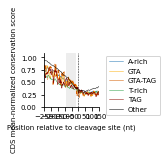

In [60]:
## Plot distribution of motif conservation scores around polyA sites

region = (-250,150)
smoothing = 10

fig,ax = plt.subplots(1,1, figsize = (1,1))

for c in sorted(mdata_spom.loc[(~mdata_spom['category'].isna()) & (mdata_spom['category'] != 'Other'), 'category'].unique().tolist()) + ['Other']:
    
    dt = msum_score_spom.loc[msum_score_spom['category'] == c]
    dc = dict(zip(dt['motifRelPos'], dt['mean']))
    
    xs = np.arange(*region,1)
    ys = np.asarray([dc.get(x,0) for x in xs]) / cds_scores['spom']['mean']
    sm = pd.Series(ys).rolling(window = smoothing, center = True).mean()
    
    sns.lineplot(x = xs, y = sm, label = c, color = mot_cmap_spom[c], linewidth = 0.5, ax = ax)

ax.axvspan(-90,-25, color = '#ededed', zorder = 1)
ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_xlabel("Position relative to cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(0,1.1)
ax.yaxis.set_major_locator(MultipleLocator(0.25))

ax.legend(bbox_to_anchor = (1.05,1), loc = 'upper left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'motif_conservation_comparison.golden_top-1.spom.mean_score.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


Category     A-rich: unique_motifs=63
Category        GTA: unique_motifs=23
Category    GTA-TAG: unique_motifs=11
Category     T-rich: unique_motifs=87
Category        TAG: unique_motifs=19
Category      Other: unique_motifs=2792


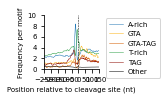

In [63]:
## Plot distribution of motif frequency around polyA sites

region = (-250,150)
smoothing = 10

fig,ax = plt.subplots(1,1, figsize = (1,1))

for c in sorted(mfilt_spom.loc[(~mfilt_spom['category'].isna()) & (mfilt_spom['category'] != 'Other'), 'category'].unique().tolist()) + ['Other']:
    print(f"Category {c:>10}: unique_motifs={mfilt_spom.loc[mfilt_spom['category'] == c, 'motif'].nunique()}")
    
    dt = msum_freq_spom.loc[msum_freq_spom['category'] == c]
    dc = dict(zip(dt['motifRelPos'], dt['count']))
    
    xs = np.arange(*region,1)
    ys = np.asarray([dc.get(x,0) for x in xs]) / mfilt_spom.loc[mfilt_spom['category'] == c, 'motif'].nunique()
    sm = pd.Series(ys).rolling(window = smoothing, center = True).mean()
    
    sns.lineplot(x = xs, y = sm, label = c, color = mot_cmap_spom[c], linewidth = 0.5, ax = ax)

ax.axvline(x = 0, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_xlabel("Position relative to cleavage site (nt)")
ax.set_xlim(region)
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.set_ylabel("Frequency per motif")
ax.set_ylim(0,10)
ax.yaxis.set_major_locator(MultipleLocator(2))

ax.legend(bbox_to_anchor = (1.05,1))
# ax.legend(bbox_to_anchor = (1.05,1), loc = 'upper left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'motif_conservation_comparison.golden_top-1.spom.frequency.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


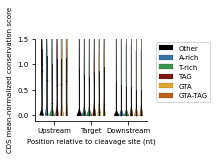


Corresponding statistics:
Wilcoxon rank-sum test for region=Upstream       T-rich vs Other: p=0.00E+00
Wilcoxon rank-sum test for region=Upstream       A-rich vs Other: p=4.32E-166
Wilcoxon rank-sum test for region=Upstream          GTA vs Other: p=8.48E-68
Wilcoxon rank-sum test for region=Upstream          TAG vs Other: p=1.42E-62
Wilcoxon rank-sum test for region=Upstream      GTA-TAG vs Other: p=7.06E-13
Wilcoxon rank-sum test for region=Target         T-rich vs Other: p=3.56E-81
Wilcoxon rank-sum test for region=Target         A-rich vs Other: p=5.05E-06
Wilcoxon rank-sum test for region=Target            GTA vs Other: p=7.44E-01
Wilcoxon rank-sum test for region=Target            TAG vs Other: p=3.74E-03
Wilcoxon rank-sum test for region=Target        GTA-TAG vs Other: p=1.01E-01
Wilcoxon rank-sum test for region=Downstream        GTA vs Other: p=2.50E-13
Wilcoxon rank-sum test for region=Downstream     A-rich vs Other: p=1.79E-05
Wilcoxon rank-sum test for region=Downstream    

In [62]:
## Assess statistical significance by comparing individual scores in the target region
## using a Wilcoxon rank sum test

fig,ax = plt.subplots(1,1, figsize = (2,1.5))

sns.violinplot(data = mfilt_spom, x = 'region', y = 'conservation_adjusted', order = ['Upstream','Target','Downstream'],
               hue = 'category', palette = mot_cmap_spom, 
               density_norm = 'area', common_norm = False, hue_norm = False,
               linewidth = 0.25, cut = 0, ax = ax)

ax.set_xlabel("Position relative to cleavage site (nt)")
ax.set_ylabel("CDS mean-normalized conservation score")
ax.set_ylim(-0.1,1.5)
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.legend(bbox_to_anchor = (1.05,1), loc = 'upper left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


print("\nCorresponding statistics:")

for r in ['Upstream','Target','Downstream']:
    rdt = mfilt_spom.loc[mfilt_spom['region'] == r]
    
    for c in rdt.loc[(~rdt['category'].isna()) & (rdt['category'] != 'Other'), 'category'].unique():

        stat, pval = st.ranksums(rdt.loc[rdt['category'] == c,       'conservation_adjusted'], 
                                 rdt.loc[rdt['category'] == 'Other', 'conservation_adjusted'])

        print(f"Wilcoxon rank-sum test for region={r:10} {c:>10} vs Other: p={pval:.02E}")

print("\nSummary data:")
print(mfilt_spom.groupby(['region','category'])['conservation_adjusted'].describe()[['count','mean','std','min','max']])
